<div style="border:solid Black 3px; padding: 40px">

# Приоритизация гипотез и анализ A/B теста интернет-магазина
    
Перед нами ряд гипотез о повышении выручки интернет-магазина и результаты A/B теста. Наша основная задача провести приоритизацию гипотез и анализ полученных данных во время теста.


Ход исследования первой части:

- загрузить данные и подготовить их для работы
- провести приоритизацию с помощью фреймворка ICE
- провести приоритизацию с помощью фреймворка RICE
- сравнить полученные результаты и объяснить их
    
Описание данных:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Ход исследования второй части:
- загрузить данные и подготовить их для работы
- построить графики кумулятивных метрик по группам, а также графики их относительного изменения
- с помощью точечных графиков и 95, 99 перцентилей установить аномальных пользователей
- с помощью теста Уилкоксона-Манна-Уитни найти статистическую значимость различий  в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным, а затем по «очищенным»
- сделать вывод

Описание orders:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.
    
Описание visitors:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Первая часть

### Загрузка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats

In [2]:
data_hyp = pd.read_csv('hypothesis.csv')

In [3]:
pd.set_option('display.max_colwidth', False)
data_hyp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
data_hyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
data_hyp['Hypothesis'].unique()

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

Перед нами 9 различных гипотез с параметрами Reach, Impact, Confidence, Efforts. Видим, что дубликатов и пропусков в данных нет и типы данных менять тоже не нужно. Значит, можем перейти к приоритизации гипотез. 

Фреймворк ICE учитывает как сильно повлияет изменение на наблюдаемую величину (Impact), уверенность в том, что повлияет именно таким образом (Confidence), а также затраты на это изменение (Efforts) ICE = Impact*Confidence/Efforts

Фреймворк RICE дополнительно учитывает количество пользователей, на которое повлияет изменение (Reach) RICE = Reach * Impact* Confidence/Efforts

### Фреймворк ICE

In [6]:
data_hyp['ICE'] = round(data_hyp['Impact']*data_hyp['Confidence']/data_hyp['Efforts'], 2)
data_hyp.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Согласно ICE самые перспективные гипотезы 8, 0, 7, а самые неперспективные - 4, 3, 5. У гипотезы-лидера практически самое большое влияние на пользователей и такая же уверенность в том, что они повлияют именно таким образом. Также введение акции на день рождения не требует максимальных затрат на тестирование.

### Фреймворк RICE

In [7]:
data_hyp['RICE'] = round(data_hyp['Impact']*data_hyp['Confidence']*data_hyp['Reach']/data_hyp['Efforts'], 2)
data_hyp.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Согласно фреймворку RICE самые переспективные гипотезы 7, 2, 0, а самые неперспективные 4, 5, 1.

`Вывод:`Видим, что из-за того, что гипотеза 8 влияет на небольшое количество людей, в рамках фреймворка RICE она сдвигается с первого на пятое место (к сожалению, День рождения только раз в году). Гипотезы 7 и 0 сохраняют лидирующие позиции, поскольку у гипотезы 7 максимальный параметр Reach (добавление формы подписки будет видно всем клиентам), а гипотеза 8 обладает максимальным Impact так как добавление канала привлечения напрямую влияет на количество покупателей. Также согласно RICE гипотеза 3 больше не является одной из самых неперспективных. Изменение структуры сайта увидят все пользователи, поэтому у гипотезы 3 высокий Reach, что и подняло её в рейтинге гипотез.

## Вторая часть

### Загрузка данных

In [6]:
orders = pd.read_csv('orders.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
orders.duplicated().sum()

0

In [8]:
visitors = pd.read_csv('visitors.csv')
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
visitors.duplicated().sum()

0

Необходимо привести столбцы с датами к типу datetime

In [14]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Итак, имеем данные о заказах (1197 строк) в интернет-магазине и его клиентах (62 строки). В данных нет пропусков и дубликатов.

В тесте участвуют группы:

In [15]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

Дата начала теста:

In [16]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

Окончание теста:

In [17]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

Уникальные сочетания группа-идентификатор пользователя

In [18]:
orders_unique = orders[['group', 'visitorId']].drop_duplicates()
orders_unique

,group,visitorId
0,B,3312258926
1,B,3642806036
2,A,4069496402
3,B,1196621759
4,B,2322279887
...,...,...
1191,B,608641596
1192,B,3733762160
1193,A,370388673
1194,A,573423106


Количество уникальных пользователей:

In [19]:
orders_unique['visitorId'].nunique()

1031

Повторяющиеся пользователи:

In [20]:
orders_unique[orders_unique['visitorId'].duplicated()==True]

,group,visitorId
41,A,237748145
114,A,4256040402
117,A,2038680547
197,A,2716752286
246,B,199603092
249,A,3234906277
252,B,3803269165
254,B,2686716486
256,A,457167155
267,B,2579882178


Количество повторяющихся пользователей

In [21]:
orders_unique[orders_unique['visitorId'].duplicated()==True].shape

(58, 2)

### График кумулятивной выручки

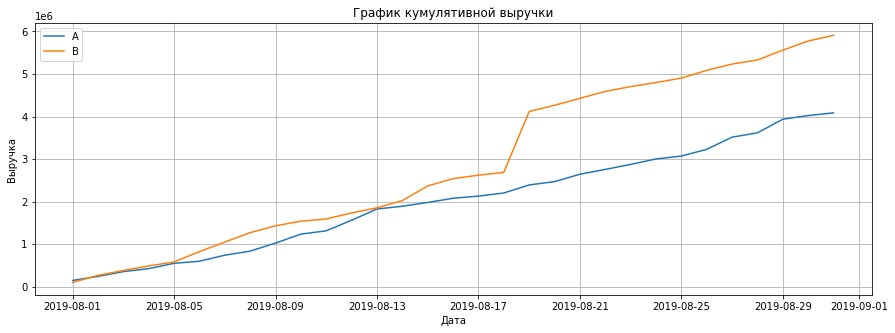

In [22]:
datesGroups = orders[['date', 'group']].drop_duplicates() # создаем массив уникальных пар значений дат и групп теста

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group']) #получаем агрегированные данные о заказах

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group']) #получаем агрегированные данные о клиентах магазина

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
) #объединяем агрегированные данные

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
] #переименовываем столбцы
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']] #получаем данные о кумулятивной выручке от группы А
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']] #получаем данные о кумулятивной выручке от группы А

plt.figure(figsize = (15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.legend()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки')
plt.show() #строим график

`Вывод:` за время тестирования выручка группы В была выше, чем у группы А, кроме первых пяти дней, когда их выручка была одинакова. Также выручка двух групп была одинакова 13 августа. После 17 августа в группе В наблюдается резкий скачок, а затем рост с примено такой же скоростью, как и у группы А (возможно скачок обусловлен аномальными значениями)

### График кумулятивного среднего чека

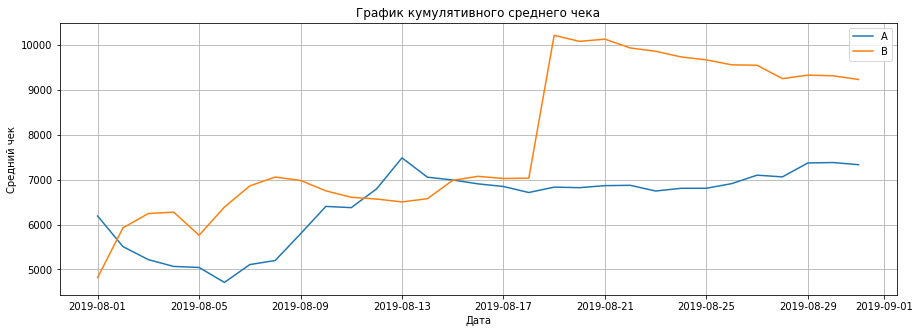

In [23]:
#находим кумулятивный средний чек для разных групп
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.figure(figsize = (15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label ='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label ='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.title('График кумулятивного среднего чека')
plt.show() #строим график

`Вывод:` величина среднего чека колебалась в течение первых двух недель, затем в группе В произошёл резкий скачок (тогда же, когда и произошёл скачок кумулятивной выручки). После скачка средний чек группы В остаётся выше, чем чек группы А.

### График относительного изменения кумулятивного среднего чека группы B к группе A

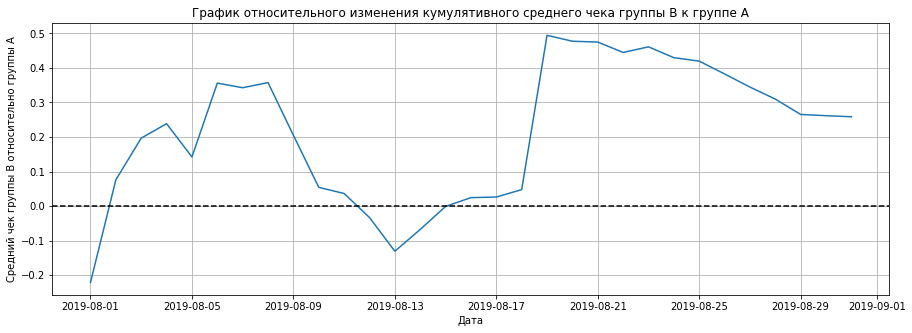

In [24]:
#объединяем таблицы с кумулятивными значениями для групп
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left', 
                                                   suffixes=['A', 'B'])

#строим график
plt.figure(figsize = (15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color = 'black', linestyle = '--')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Средний чек группы B относительно группы А')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

`Вывод:` в начале теста средний чек группы В был выше, но затем наблюдается спад. Затем произошёл резкий скачок и медленное падение, что говорит о том, что средний чек группы В был выше, но разница начала уменьшаться.

### График кумулятивного среднего количества заказов на посетителя

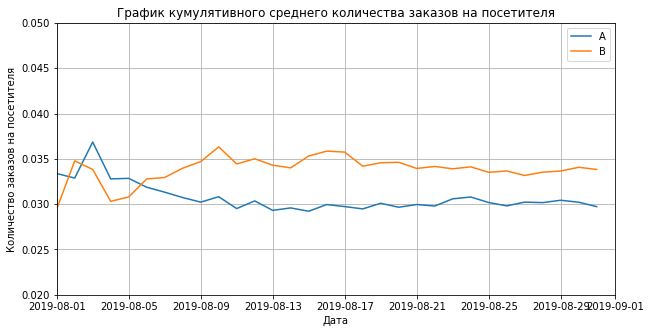

In [25]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize = (10, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label = 'B')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.02, 0.05])
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество заказов на посетителя')
plt.grid()
plt.title('График кумулятивного среднего количества заказов на посетителя')
plt.show()

`Вывод:` видим, что среднее количество заказов на посетителя в группе В стабильно выше, чем в группе А.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

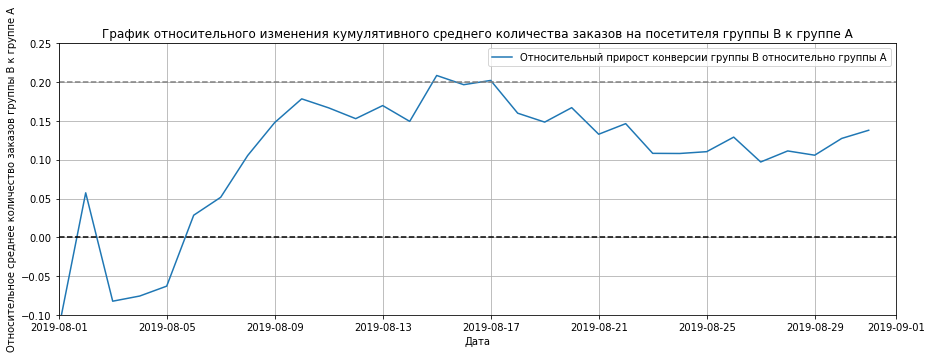

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']],
                                                                            left_on='date',
                                                                           right_on='date',
                                                                           how='left',
                                                                           suffixes=['A', 'B'])


plt.figure(figsize = (15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
        label = "Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle = '--')
plt.axhline(y=0.2, color='grey', linestyle = '--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.1, 0.25])
plt.legend()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Относительное среднее количество заказов группы В к группе А')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show()

`Вывод:` среднеее количество заказов на посетителя в группе В выше почти с самого начала тестирования

### Точечный график количества заказов по пользователям

In [27]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId':'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


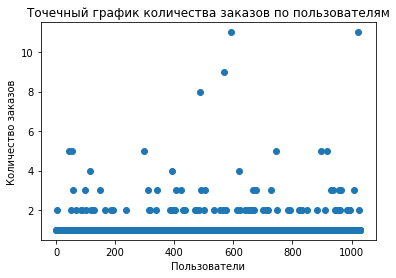

In [28]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

`Вывод:` большинство пользователей заказывали 1-2 раза. Единицы пользователй с 8-11 заказами

### 95-й и 99-й перцентили количества заказов на пользователя

In [29]:
np.percentile(ordersByUsers['orders'], [95, 99])


array([2., 4.])

`Вывод:` не более 5% пользователей совершили больше 2 заказов, и не больше 1% совершили более 4 заказов. Можем принять за аномальных пользователей тех, кто совершил 4 и более заказов.

### Точечный график стоимостей заказов

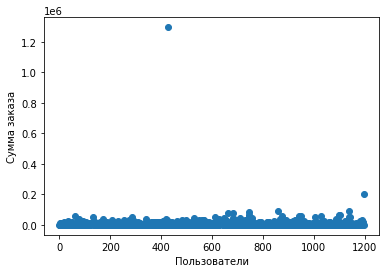

In [30]:
orders.sort_values(by='revenue', ascending=False)

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Пользователи')
plt.ylabel('Сумма заказа')
plt.show()

`Вывод:` Видим один заказ больше чем на 1200000! И ещё один приблизительно на 200000. Все остальные заказы плохо различимы, можно задать значения оси.

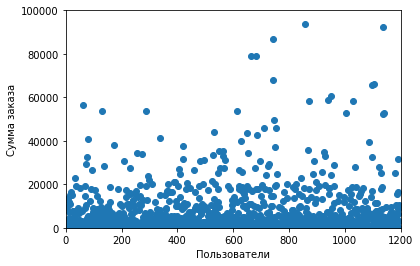

In [31]:
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 100000])
plt.xlabel('Пользователи')
plt.ylabel('Сумма заказа')
plt.show()

`Вывод:` основное количество заказов меньше, чем на 20000. Несколько на 80000-100000.

### 95-й и 99-й перцентили стоимости заказов

In [32]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

`Вывод:` не более 5% совершили заказ больше, чем на 28000, и не более 1% процента пользователей  совершили заказ более, чем на 58233. Примем за аномальных пользователей тех, кто совершил заказ на 28000 или больше

###  Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

`Гипотезы:`
- H0: различий в среднем количестве заказов между группами нет. 

- H1: различия в среднем между группами есть.

In [33]:
# информация о посетителях в группе А по дням
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# # информация о посетителях в группе В по дням
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#  количество пользователей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# информация о заказах в группе А по дням
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# суммарное число заказов до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# информация о заказах в группе В по дням
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# суммарное число заказов до выбранной даты включительно в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединяем все данные
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [34]:
# заказы пользователей из группы А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

# заказы пользователей из группы А
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# объявляем переменные с количеством заказов каждого посетителя по группам
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()- len(ordersByUsersA['orders'])), name = 'orders')], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()- len(ordersByUsersB['orders'])), name = 'orders')], axis=0)

"p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])


'p-value: 0.017'

In [35]:
"различие в средних: {0:.3f}".format(sampleB.mean()/sampleA.mean() -1)

'различие в средних: 0.138'

`Вывод:` p-value меньше 0,05 (0,017), что означает, что мы отвергаем нулевую гипотезу о равенстве средних количеств заказа в "сырых" данных. Относительный прирост среднего группы В к группе А 13,8%

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

`Гипотезы:`

- H0: средний чеке между группами равен
- H1: средний чеке между группами неравен

In [36]:
'p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])


'p-value: 0.729'

In [37]:
'различие в средних: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'различие в средних: 0.259'

`Вывод:` p-value больше 0,05 (0,729), что означает, что мы не отвергаем нулевую гипотезу о равенстве средних чеков в "сырых" данных. Относительный прирост среднего чека группы В к группе А составляет целых 25,9% (может говорить о наличии аномалий, проверим)

###  Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

За аномальных пользователей принимаем тех клиентов, которые совершили 4 и более заказов (1%), или тех, кто совершил заказ на 30000 и более (1%-5%)

In [38]:
anomal_amount=np.percentile(ordersByUsers['orders'], [99])
anomal_amount = [int (x) for x in anomal_amount]

anomal_revenue = np.percentile(orders['revenue'], [95])
anomal_revenue = [int (x) for x in anomal_revenue]

# находим аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders']>= anomal_amount[0]]['userId'],
        ordersByUsersB[ordersByUsersB['orders']>= anomal_amount[0]]['userId']
    ],
    axis=0
)
usersWithExpensiveOrders = orders[orders['revenue']>= anomal_revenue[0]]['visitorId']
abnormalUsers =(
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
    
)
abnormalUsers.head()

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
dtype: int64

In [39]:
abnormalUsers.shape

(63,)

Нашли 57 аномальных пользователей. теперь проверим гипотезы.

- H0: различий в среднем количестве заказов между группами нет. 

- H1: различия в среднем между группами есть.


In [40]:
# пользователи в группе А после удаления аномальных значений
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# пользователи в группе B после удаления аномальных значений
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
'p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])


'p-value: 0.018'

In [41]:
'различие в средних: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

'различие в средних: 0.148'

`Вывод:` p-value меньше 0,05 (0,018), что означает, что мы отвергаем нулевую гипотезу о равенстве средних количеств заказа в "очищенных" данных. Относительный прирост среднего группы В к группе А 14,8%. Несмотря на фильтрацию аномальных пользователей общая картина изменилась не сильно.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

`Гипотезы:`

- H0: средний чек между группами равен
- H1: средний чек между группами неравен

In [42]:
cheks_a = (
    orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']
)

cheks_b = (
    orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']
)
'p-value: {0:.3f}'.format(stats.mannwhitneyu(cheks_a, cheks_b)[1])

'p-value: 0.977'

In [43]:
'{0:.3f}'.format(cheks_b.mean()/cheks_a.mean()-1)

'-0.017'

`Вывод:` p-value по-прежнему больше 0,05 (0,977), что означает, что мы не отвергаем нулевую гипотезу о равенстве средних чеков в "очищенных" данных. А вот относительный прирост среднего чека группы В к группе А сильно изменился и теперь составляет только 1,7%.

### Результаты

- Есть статистически значимое различие в среднем количистве заказов на посетителя между группами как по сырым данным, так и после фильтрации аномалий.

- Нет статистически значимого различия по среднему чеку между группамикак по сырым данным, так и после фильтрации аномалий.

- График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A сообщает, что результаты группы B лучше группы A: наблюдается резкий скачок в начале теста и достаточно стабильное значение в оставшийся период (около 20%)

На основании перечисленного приходим к выводу, что тест успешный и его можно останавливать.

## Выводы

`Первая часть:`

- получили 9 различных гипотез с параметрами Reach, Impact, Confidence, Efforts
- по полученным данным провели приоритизацию гипотез согласно фреймворкам ICE, RICE.
- согласно ICE самая перспективная гипотеза 8 ('Запустить акцию, дающую скидку на товар в день рождения')
- согласно RICE самая перспективная гипотеза 7 ('Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок')
- разница обусловлена учитыванием параметра Reach, у гипотезы 7 он в 10 раз больше.

`Вторая часть:`

- получили данные о заказах (1197 строк) в интернет-магазине и его клиентах (62 строки)
- за время тестирования выручка группы В была выше, чем у группы А
- спустя 2 недели средняя выручка группы В резко возросла и была больше до конца теста, на графике отношения средних выручек это видно
-  среднее количество заказов на посетителя в группе В стабильно выше, чем в группе А
-  не более 5% пользователей совершили больше 2 заказов, и не больше 1% совершили более 4 заказов
-  не более 5% совершили заказ больше, чем на 28000, и не более 1% процента пользователей совершили заказ более, чем на 58233
-  по "сырым" данным мы отвергаем нулевую гипотезу о равенстве средних количеств заказа, ситуация не меняется после фильтрации аномальных пользователей
- по "сырым" данным мы не отвергаем нулевую гипотезу о равенстве средних чеков, ситуация не меняется после фильтрации аномальных пользователей
-  тест успешный и его можно останавливать 